# Who's That Pokemon!

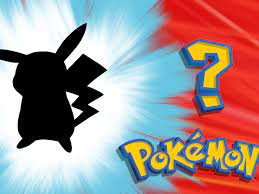




### In this project we will create our own real world PokeDex by using a Convolutional Neural Network & Transfer Learning



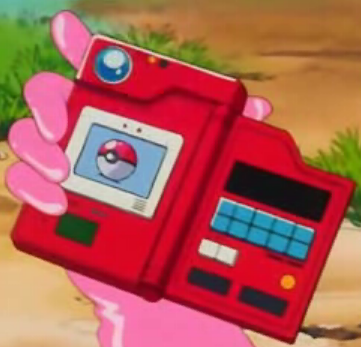

## After completing this project I learned:
- How to prepare our dataset
- How to process our dataset
- The process of Convolutional Neural Networks
- How to implement transfer learning to increase our accuracy
- About VGG16 dataset competition

## First Steps

### Preparing our dataset
Where I got the pokemon image dataset:
https://www.kaggle.com/lantian773030/pokemonclassification  

- Once downloaded we need to split the images into training and validation.  
- We need created a local script that would seperate it the data into 80% training and 20% validation.
- We then upload the dataset into a personal google drive so it can be mounted by google colab



### Creating our script to split our training and validation

Our dataset after the script

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>PokemonDataset</b>
|__ <b>train</b>
    |______ <b>Abra</b>: [5d5e1a5d.png, 5d781d5.jpg, a54d5d2.jpg ....]
    |______ <b>Aerodactyl</b>: [d54a51dd.jpg, 5c4d85a.jpeg, 5y45h85.jpg ...]
|__ <b>val</b>
    |______ <b>Abra</b>: [g415g2ff.png, 51f51f5d.jpg, 398d89d.jpeg ....]
    |______ <b>Aerodactyl</b>: [kj6k18jn.png, 2355h5g.jpg, 8g451f5g.jpg ...]
</pre>

# Google Drive authorization
First we will need to mount our dataset we uploaded from google we can do this by importing drive and passing in our content directory



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Importing the neccessary packages  

- We need to os, glob to help access and use our image dataset
- cv2 will allow us to read and resize our images
- Tensorflow will be our man package used for creating our convolutional neural network.
- Matplotlib will used to plot and visually see our results.

In [ ]:
import os
import numpy as np
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
train_dir = "/content/drive/MyDrive/PokemonData/train/*"
val_dir = "/content/drive/MyDrive/PokemonData/val/*"
train_classes = os.listdir("/content/drive/MyDrive/PokemonData/train")
pokemon_class = os.listdir("/content/drive/MyDrive/PokemonData")
pokenum = len(train_classes)


In [ ]:
batch_size = 32
IMG_SHAPE = (224,224)

## Preprocessing our Images

We will need to process our dataset  
We will do this by taking in a directory in the params and walk through each images by reading and resize our images to 224,224.  
It will then return our images and labels in a numpy array.


#### processing on our training dataset

In [ ]:
train_images = []
train_labels = []
train_count = 0
for directory_path in glob.glob(train_dir):
  label = directory_path.split("/")[-1]
  train_count += 1
  for img_path in glob.glob(os.path.join(directory_path, "*")):
    try:
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, IMG_SHAPE)
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    except:
      break
    train_images.append(img)
    train_labels.append(label)
  print(f'\rCompleted: {label} there are {pokenum - train_count} remaining',end='')

train_images = np.array(train_images)
train_labels = np.array(train_labels)

Completed: Beedrill there are 0 remaining

#### processing our validation dataset

In [ ]:
val_images = []
val_labels = []
val_count = 0
for directory_path in glob.glob(val_dir):
  label = directory_path.split("/")[-1]
  val_count += 1
  for img_path in glob.glob(os.path.join(directory_path, "*")):
    try:
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, IMG_SHAPE)
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    except:
      pass
    val_images.append(img)
    val_labels.append(label)
  print(f'\rCompleted: {label} there are {pokenum - val_count} remaining',end='')

val_images = np.array(train_images)
val_labels = np.array(train_labels)

Completed: Bellsprout there are 0 remaining

We import LabelEncoder to convert our labels into machine learning numerical form.

In [ ]:
from sklearn import preprocessing

labels_encode = preprocessing.LabelEncoder()

# Encoding our Validation labels
labels_encode.fit(val_labels)
val_labels_encoded = labels_encode.transform(val_labels)

# Encoding our Training labels
labels_encode.fit(train_labels)
train_labels_encoded = labels_encode.transform(train_labels)

In [ ]:
# Splitting our data into train and validation (Assigning it into more meaningful)
x_train, y_train, x_val, y_val = train_images, train_labels_encoded, val_images, val_labels_encoded

All of our values are 8-bit images so the value goes from 1 to 255. We want to scale the values of the pixels to 0 and 1 so we will divide the pixels by 255.

In [ ]:
x_train, x_val = x_train / 255.0, x_val / 255.0

Here are some images after processing our Images.  
(Images are out of order from the Labels)

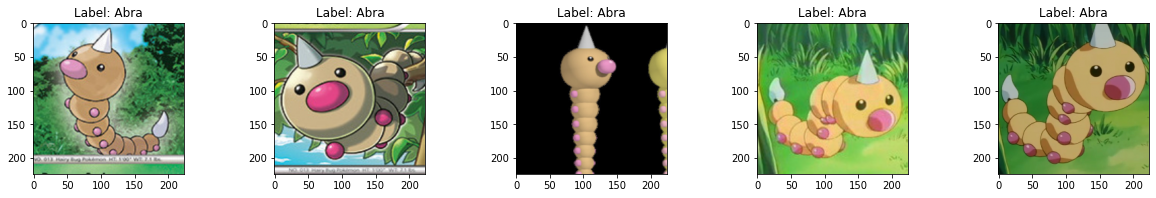

In [ ]:
plt.figure(figsize = (20, 10))
c = 0
for i in range(5):
  c += 1
  plt.subplot(1,5,c)
  plt.subplots_adjust(hspace = .9, wspace = .6)
  plt.imshow(x_train[i])
  plt.title(f'Label: {train_classes[y_train[i]]}')

We import to_categorical from keras to convert our labels into one hot encoding format.  
This is how machine learning model interprets our labels.
One-hot encoding is a vector of zeros and ones that classifies our labels.  
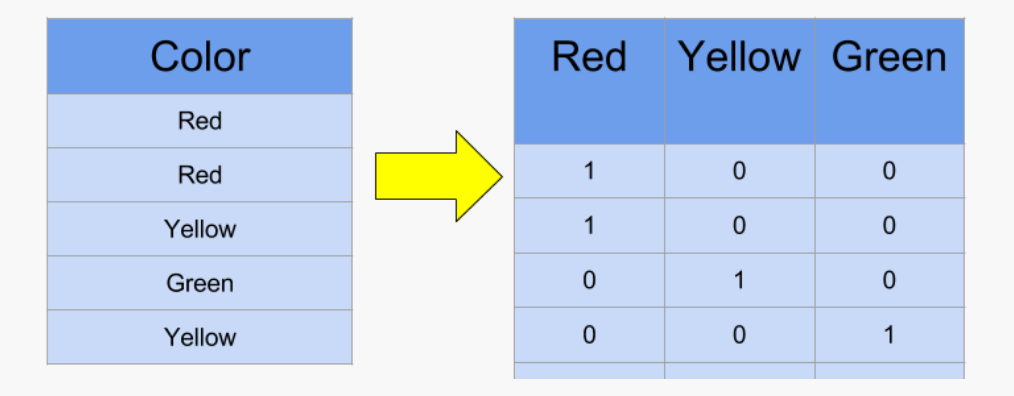


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

# Transfer learning with VGG16


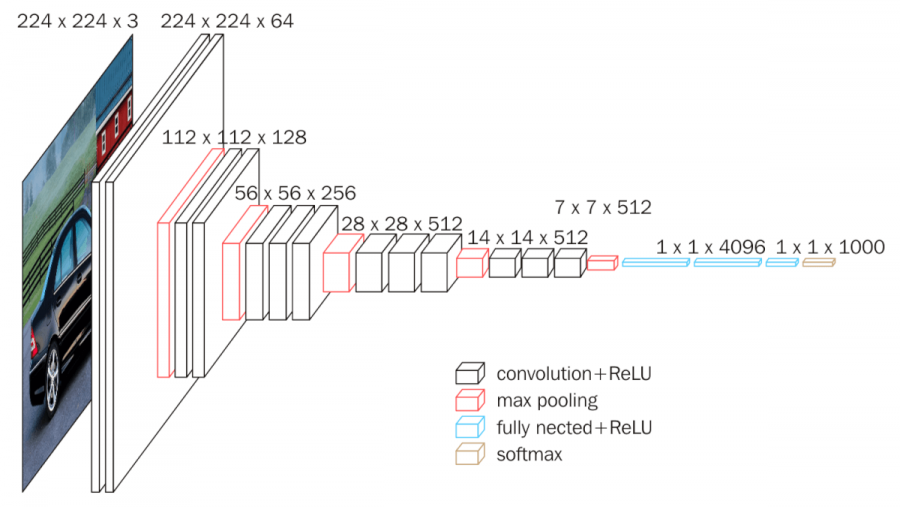

Instead of creating our own model with random weights.  
We can use transfer learning with Models that has been trained with over millions of images.  
This allows for the best predicted output that we can use as features to so we can feed it through our Random Forest model.

We begin by importing our vgg16 model without the last dense layers and get the imagenet weights.

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                weights='imagenet',
                                                input_shape=(224,224,3),
                                                )

58900480/58889256 [==============================] - 1s 0us/step


Here are the layers that are in vgg16

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We want to freeze those layers and make then untrainable because vgg16 already has done work for us and we want to keep that weights constant.

This is how we import our feature extractor

In [ ]:
for layer in vgg16_model.layers:
  layer.trainable = False

Now that we have our model want to send our input data through our feature extractor.  

We will using Random Forest for training and random forest expects a single column. So we will be reshaping our feature extractor to one column.

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=vgg16_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF
  

In [ ]:
print(feature_extractor)

[[[[1.2737552  0.         0.32017654 ... 0.         1.2502635
    0.        ]
   [0.7296902  0.         0.0818623  ... 0.08622566 0.8595165
    0.        ]
   [0.22630358 0.         0.28906173 ... 0.         0.5194261
    0.        ]
   ...
   [0.5676731  0.         0.33408874 ... 0.         0.8586454
    0.        ]
   [0.         0.         2.4422503  ... 0.         0.60846746
    0.        ]
   [0.51970446 0.         2.1944082  ... 0.         0.6796733
    0.        ]]

  [[0.08144212 0.         1.0184814  ... 0.         1.1349301
    0.        ]
   [1.4814138  0.         0.6985376  ... 0.30352315 0.81777644
    0.        ]
   [1.9650966  0.         0.6232566  ... 0.         0.5090852
    0.        ]
   ...
   [0.53590226 0.         1.8699906  ... 0.         0.83723414
    0.        ]
   [0.24160415 0.         2.591926   ... 0.         0.6737487
    0.        ]
   [0.6857126  0.         2.0271041  ... 0.         0.41265446
    0.        ]]

  [[0.         0.         1.3985839  ... 0

In [ ]:
print(x_train)

[[[[0.94509804 0.9254902  0.91372549]
   [0.94901961 0.9372549  0.91764706]
   [0.95294118 0.94901961 0.91764706]
   ...
   [0.00392157 0.5372549  0.36470588]
   [0.00784314 0.51372549 0.34509804]
   [0.01568627 0.49019608 0.32941176]]

  [[0.96470588 0.96078431 0.95686275]
   [0.95686275 0.94509804 0.9372549 ]
   [0.95686275 0.93333333 0.91372549]
   ...
   [0.09803922 0.56862745 0.39215686]
   [0.10588235 0.54901961 0.38431373]
   [0.10588235 0.51764706 0.36862745]]

  [[0.98823529 0.98823529 0.99607843]
   [0.97647059 0.96078431 0.96470588]
   [0.96470588 0.9372549  0.93333333]
   ...
   [0.17647059 0.58823529 0.40392157]
   [0.18431373 0.57647059 0.40392157]
   [0.17647059 0.54509804 0.38823529]]

  ...

  [[0.38431373 0.70980392 0.43137255]
   [0.39607843 0.71764706 0.43921569]
   [0.40784314 0.7254902  0.44705882]
   ...
   [0.24313725 0.67843137 0.39215686]
   [0.24313725 0.69019608 0.39607843]
   [0.23137255 0.70588235 0.4       ]]

  [[0.40784314 0.71372549 0.44705882]
   [0.4

In [ ]:
print(len(features[0]))

25088


### Creating our RandomForestClassifier model

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

### Train the model on training data

In [ ]:
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

We will do the same thing with our validation images send those input data through our feature extractor.  
Also reshaping them into one columun for our RandomForest moduel

In [ ]:
#Send test data through same feature extractor process
X_val_feature = vgg16_model.predict(x_val)
X_val_features = X_val_feature.reshape(X_val_feature.shape[0], -1)
# X_val_features = x_val.reshape(x_val.shape[0], -1)

Now we are going to make some prediction on our RandomForest Model  

We will pass in the extracted features from vgg16 through the RandomForest model predict method and decode our labels. 

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_val_features)

#Inverse encoded labels transform to get original label back. 
prediction_RF = labels_encode.inverse_transform(prediction_RF)

# We got an outstanding accuracy of .999 percent!

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(val_labels, prediction_RF))

Accuracy =  0.999626307922272


## Here we can check results on a few select images

The prediction for this image is:  ['Paras']
The actual label for this image is:  Paras


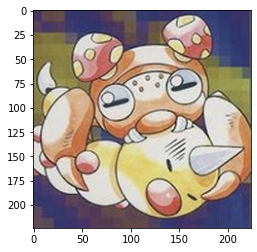

In [ ]:

n=np.random.randint(0, x_val.shape[0])
img = x_val[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=vgg16_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img.shape[0], -1)
# input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = labels_encode.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", val_labels[n])